In [1]:
%matplotlib inline

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
from mvpose.data import epfl_campus

root = Settings['data_root']
root = join(root, 'pak')
tmp = Settings['tmp']

# FRAME = 800
# X, Y, Calib = epfl_campus.get(root, FRAME)

# fig = plt.figure(figsize=(16,16))

# COLORS = ['red', 'green', 'blue', 'yellow']

# for cid in [0, 1, 2]:
#     ax = fig.add_subplot(1, 3, cid+1)
#     cam = Calib[cid]
#     im = X[cid]
#     ax.imshow(im)
#     ax.axis('off')
    
#     for pid, person in enumerate(Y):
#         pts3d = person
#         if pts3d is None:
#             continue
        
#         pts2d = cam.projectPoints(pts3d)
#         for u, v in pts2d:
#             ax.scatter(u, v, color=COLORS[pid])

# plt.show()

# Evaluation frames:
[350 - 470] and [650 - 750].

In [2]:
# # ==================================
# from mvpose import pose
# from mvpose.algorithm import graphcut
# from mvpose.algorithm.settings import get_settings
# import paf_loader


# FRAME = 350
# Im, Y, Calib = epfl_campus.get(root, FRAME)

# heatmaps, pafs = paf_loader.load_confidence_map_and_paf('campus', 
#                                                         Im, 
#                                                         FRAME, 
#                                                         dir=tmp)

# Debug, detections = pose.estimate(Calib, heatmaps, pafs,
#                                   settings=param,
#                                   debug=True)

# Step 1: generate HMs and PAFs

In [3]:
# import json
# Settings = json.load(open('../settings.txt'))
# import matplotlib.pyplot as plt
# import numpy as np
# from os.path import join
# from cselect import color as cs
# import sys
# sys.path.insert(0,'../')
# sys.path.insert(0,'../samples')
# from mvpose.data import epfl_campus
# # ==================================
# from mvpose import pose
# from mvpose.algorithm import graphcut
# from mvpose.algorithm.settings import get_settings
# import paf_loader
# from mvpose.plot.limbs import draw_mscoco_human

# root = Settings['data_root']
# root = join(root, 'pak')
# tmp = Settings['tmp']

# def exec_frame(frame):
#     Im, Y, Calib = epfl_campus.get(root, frame)
#     heatmaps, pafs = paf_loader.load_confidence_map_and_paf('campus', 
#                                                         Im,
#                                                         frame,
#                                                         dir=tmp)
#     del Im
#     del Y
#     del Calib
#     del heatmaps
#     del pafs


# for frame in range(747, 750):
#     print('handling frame ', frame)
#     exec_frame(frame)
# 

# Step 2: generate candidates

In [4]:
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
from mvpose.data import epfl_campus

root = Settings['data_root']
root = join(root, 'pak')
tmp = Settings['tmp']

from mvpose import pose
from mvpose.algorithm import graphcut
from time import time
from mvpose import pose
from mvpose.algorithm import graphcut
from mvpose.algorithm.settings import get_settings
import paf_loader

# --- Things that kinda have to be parametrized ---
candidate_main_name = 'campus_candidates_frame'
dict_file = join(tmp, 'campus_scores.npy')
params = get_settings(scale_to_mm=1000)
# -------------------------------------------------

# def execute(FRAME):
#     global params, candidate_main_name
#     Im, Y, Calib = epfl_campus.get(root, FRAME)
#     print('\nframe:', FRAME)
#     heatmaps, pafs = paf_loader.load_confidence_map_and_paf('campus', 
#                                                             Im, 
#                                                             FRAME, 
#                                                             dir=tmp)
#     _start = time()
# #     detections = pose.estimate_heuristic(
# #         Calib, heatmaps, pafs, settings=params, 
# #         debug=False, use_greedy=False)
#     detections = pose.estimate(
#         Calib, heatmaps, pafs, settings=params, 
#         debug=False)
#     _end = time()
#     print('total elapsed:', _end - _start)
    
#     # -- store to file --
#     candidate_name = candidate_main_name + str(FRAME) + ".npy"
#     candidate_name = join(tmp, candidate_name)
#     np.save(candidate_name, detections)
    
#     del heatmaps
#     del pafs
#     del detections
#     del Im
#     del Y
#     del Calib

# def run_all():
#     # 350 - 470 + 650 - 750
#     for f in range(738, 750):
#         execute(f)

# run_all()

/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Step 3: calculate re-id score

In [5]:
from mvpose.algorithm.track_graph_partitioning import get_bb, distance3d_humans, ValidImageCandidateExtractor
from mvpose.tracking import extend_calibration_to_frames
from os.path import join, isdir, isfile
from reid import reid

from mvpose.algorithm.settings import get_settings, get_tracking_settings

#reid_model = reid.ReId()
reid_model = {}  # we can skip this ONLY if we already calc. reid scores!
tracking_params = get_tracking_settings(params, 
                                        low_spec_mode=True, 
                                        reid_model=reid_model,
                                        max_moving_distance_per_frame=1000000,
                                        valid_person_bb_area=50,
                                        personreid_batchsize=2)

valid_frames = list(range(350, 470)) + list(range(650, 750))
n_frames = len(valid_frames)
graph_3d = {}
human_candidates = []
Im = []

# 350 - 470 + 650 - 750
for frame in valid_frames:
    if frame % 50 == 0:
        print('frame ', frame)
    candidate_name = candidate_main_name + str(frame) + ".npy"
    candidate_name = join(tmp, candidate_name)
    assert isfile(candidate_name)
    Humans = np.load(candidate_name)
    human_candidates.append(Humans)
    im, Y, Calib = epfl_campus.get(root, frame)
    Im.append(im)
Im = np.array(Im, 'uint8')

print(len(human_candidates))

Calibs = extend_calibration_to_frames([Calib], n_frames)

img_cand = ValidImageCandidateExtractor(Im, human_candidates, Calibs, tracking_params)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# n = len(img_cand.ImgsA)
# print('n=', n)
# start = 0
# if isfile(dict_file):
#     start = np.load(dict_file).item()['next_frame']

# print('start:' + str(start) + ' until ' + str(n))
# for frame in range(start, n):
#     if isfile(dict_file):
#         storage = np.load(dict_file).item()
#     else:
#         storage = {}
    
#     if frame % 10 == 0:
#         print('frame %05d/' % (frame+1) + str(n))
#         _start = time()
#     A = img_cand.ImgsA[frame]
#     B = img_cand.ImgsB[frame]
#     score = np.squeeze(reid_model.predict(A, B))
#     #print('storage', storage)
#     #print('score', score)
#     storage[frame] = score
#     storage['next_frame'] = frame + 1
#     np.save(dict_file, storage)
#     if frame % 10 == 0:
#         _end = time()
#         print('\telapsed', _end - _start)
#     del storage

frame  350
frame  400
frame  450
frame  650
frame  700
220


# Step 4: build graph

In [6]:
# from mvpose.algorithm.track_graph_partitioning import generate_graph3d, GraphSolver
# from mvpose.algorithm.track_graph_partitioning import construct_query_graph
# from mvpose.tracking import extract_tracks

# storage = np.load(dict_file).item()

# scores = []
# pairs = img_cand.pairs
# n = len(img_cand.ImgsA)
# print(n)

# assert(len(pairs) == n)
# for frame in range(n):
#     scores.append(storage[frame])
# assert len(scores) == n


# graph_3d = generate_graph3d(scores, pairs)  # t1, pid1, t2, pid2

# n_frames_red = len(human_candidates)
# graph_partitioning = GraphSolver(graph_3d, 
#                                  n_frames_red,
#                                  tracking_params.T)


# G = construct_query_graph(graph_partitioning, n_frames_red)

# tracks = extract_tracks(human_candidates, G)

# Step 5: PCP for single individuals

In [7]:
from mvpose.evaluation import pcp
import mvpose.data.kth_football2 as kth
import mvpose.data.skeleton_augmentation as ska
model_path = '../data/model_poseprediction.h5'
gen = ska.LimbGenerator(model_path, params.scale_to_mm)

def generate_pcp_score(frame):
    alpha = 0.5
    candidate_name = candidate_main_name + str(frame) + ".npy"
    candidate_name = join(tmp, candidate_name)
    assert isfile(candidate_name)
    candidates = np.load(candidate_name)
    candidates = gen.apply(candidates)
    Humans = kth.transform3d_from_mscoco(candidates)
    
    Im, Y, Calib = epfl_campus.get(root, frame)
    
    L_Arms = []
    U_Arms = []
    L_Legs = []
    U_Legs = []
    Avg = []
    GTIDs = []
  
    for gtid, gt in enumerate(Y):
        if gt is None:
            continue
        
        larms = 0
        uarms = 0
        llegs = 0
        ulegs = 0
        avg = 0
        for d in Humans:
            r = pcp.evaluate(gt, d, alpha)
            larms_ = r.lower_arms
            uarms_ = r.upper_arms
            ulegs_ = r.upper_legs
            llegs_ = r.lower_legs
            avg_ = (larms_ + uarms_ + ulegs_ + llegs_) / 4
            if avg_ > avg:
                avg = avg_
                larms = larms_
                uarms = uarms_
                llegs = llegs_
                ulegs = ulegs_
        
        L_Arms.append(larms)
        U_Arms.append(uarms)
        L_Legs.append(llegs)
        U_Legs.append(ulegs)
        Avg.append(avg)
        GTIDs.append(gtid)
    
    del candidates
    del Im
    del Y
    del Calib
    
    return L_Arms, U_Arms, L_Legs, U_Legs, Avg, GTIDs
    
PER_GTID = {}
for idx, frame in enumerate(valid_frames):
    L_Arms, U_Arms, L_Legs, U_Legs, Avg, GTIDs =\
        generate_pcp_score(frame)
    
    if len(L_Arms) > 0:
        for gtid, larms, uarms, llegs, ulegs, avg in zip(
            GTIDs, L_Arms, U_Arms, L_Legs, U_Legs, Avg
        ):
            if not gtid in PER_GTID:
                PER_GTID[gtid] = {
                    'larms': [],
                    'uarms': [],
                    'llegs': [],
                    'ulegs': [],
                    'avg': [],
                    'frame': []
                }
            PER_GTID[gtid]['larms'].append(larms)
            PER_GTID[gtid]['uarms'].append(uarms)
            PER_GTID[gtid]['llegs'].append(llegs)
            PER_GTID[gtid]['ulegs'].append(ulegs)
            PER_GTID[gtid]['avg'].append(avg)
            PER_GTID[gtid]['frame'].append(frame)
            
    
print('done')

done


Frame= 716
PCP:
  gtid = 0
	larms = 0.5
	uarms = 0.5
	llegs = 1.0
	ulegs = 1.0
	avg = 0.75
  gtid = 1
	larms = 0.5
	uarms = 1.0
	llegs = 1.0
	ulegs = 1.0
	avg = 0.875
  gtid = 2
	larms = 0.5
	uarms = 0.5
	llegs = 1.0
	ulegs = 1.0
	avg = 0.75


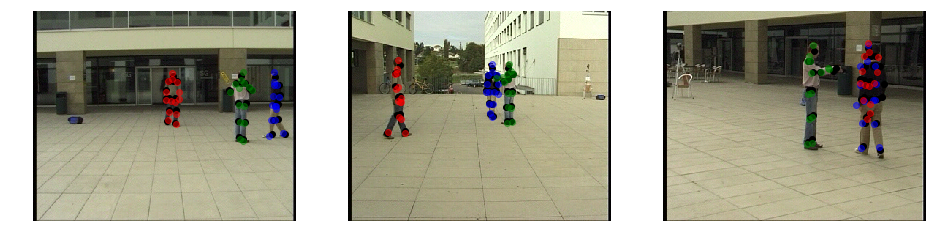

In [8]:
from mvpose.evaluation import pcp
import mvpose.data.kth_football2 as kth
from mvpose.algorithm.candidate_selection import project_human_to_2d

#frame = valid_frames[29]
frame = 716
print('Frame=', frame)
Im, Y, Calib = epfl_campus.get(root, frame)

candidate_name = candidate_main_name + str(frame) + ".npy"
candidate_name = join(tmp, candidate_name)
assert isfile(candidate_name)
candidates = np.load(candidate_name)
#candidates = gen.apply(candidates)
Humans = kth.transform3d_from_mscoco(candidates)

fig = plt.figure(figsize=(16,10))

GT_COLORS = ['blue', 'green', 'red']

for cid ,(im, cam) in enumerate(zip(Im, Calib)):
    ax = fig.add_subplot(1, 3, cid+1)
    ax.axis('off')
    ax.imshow(im)
    for human in Humans:
        human2d = project_human_to_2d(human, cam)
        for pt2d in human2d:
            if pt2d is None:
                continue
            x, y = pt2d
            ax.scatter(x, y, color='black')
        
    for gtid, gt in enumerate(Y):
        if gt is None:
            continue
        gt2d = cam.projectPoints(gt)
        for x, y in gt2d:
            ax.scatter(x, y, color=GT_COLORS[gtid], alpha=0.5)


            
print('PCP:')
L_Arms, U_Arms, L_Legs, U_Legs, Avg, GTIDs = generate_pcp_score(frame)
for gtid, larms, uarms, llegs, ulegs, avg in zip(
        GTIDs, L_Arms, U_Arms, L_Legs, U_Legs, Avg
    ):
    print('  gtid =', gtid)
    print('\tlarms =', larms)
    print('\tuarms =', uarms)
    print('\tllegs =', llegs)
    print('\tulegs =', ulegs)
    print('\tavg =', avg)


plt.show()

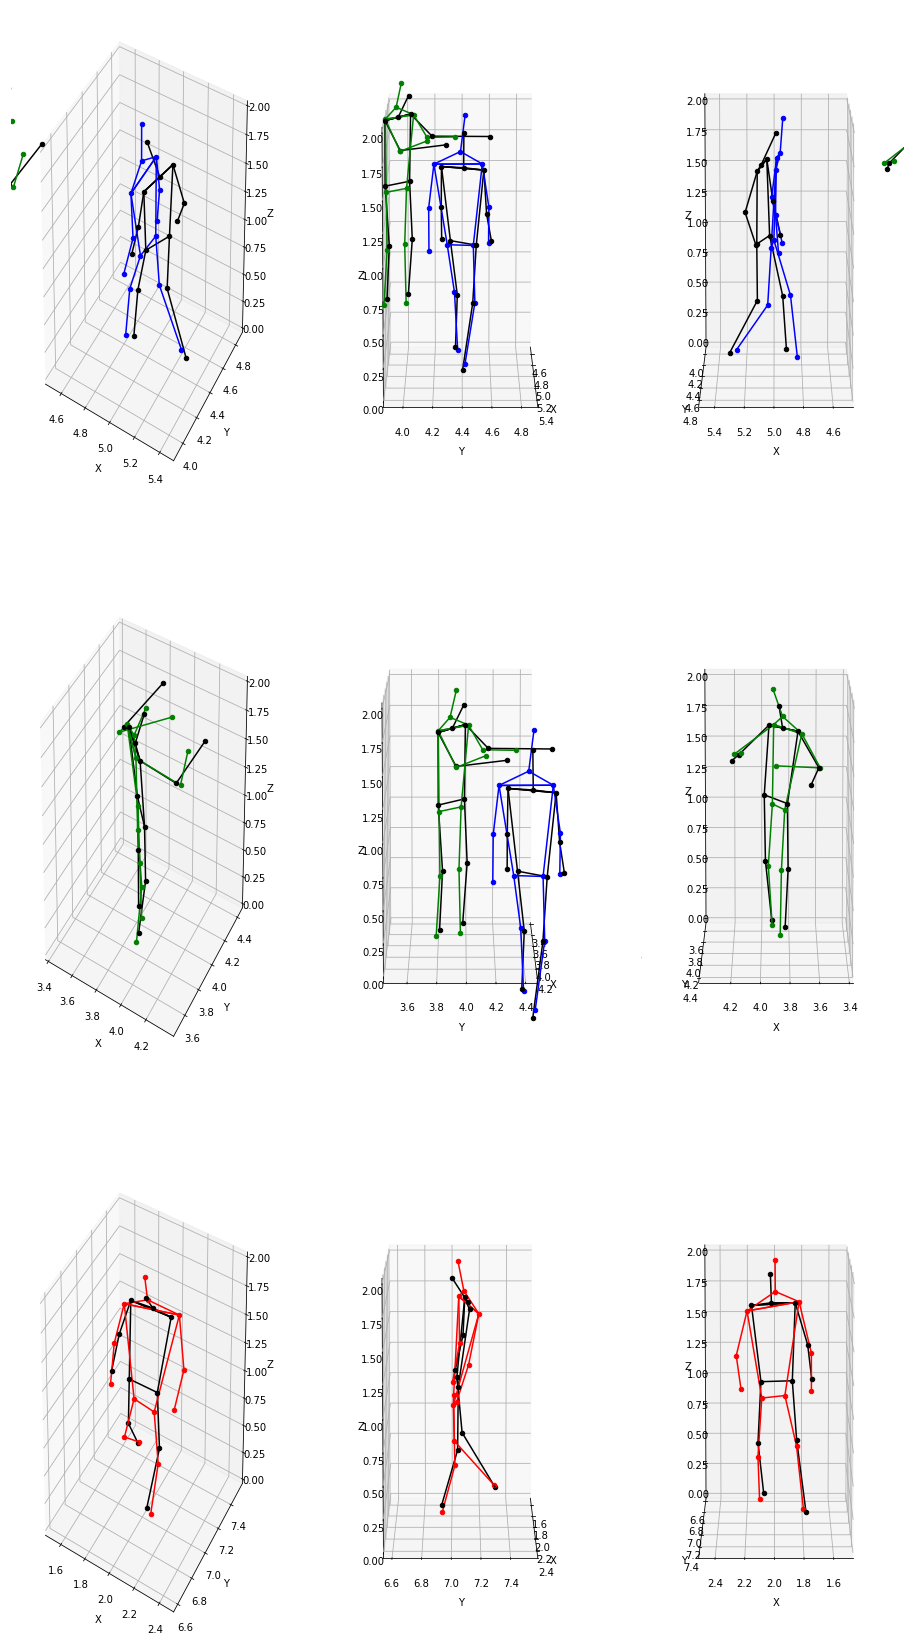

In [9]:
from mpl_toolkits.mplot3d import Axes3D

def plot_human(ax, human, color):
    for pt3d in human:
        if pt3d is None:
            continue
        ax.scatter(pt3d[0], pt3d[1], pt3d[2], color=color)
        
    
    limbs = [
        (0, 1), (1, 2), (2, 3), (3, 4), (4, 5),
        (6, 7), (7, 8), (8, 9), (9, 10), (10, 11),
        (8, 12), (9, 12), (8, 9), (12, 13),
        (2, 8), (3, 9)
    ]
    
    for a, b in limbs:
        ptA = human[a]
        ptB = human[b]
        if ptA is None or ptB is None:
            continue
        x1, y1, z1 = ptA
        x2, y2, z2 = ptB
        ax.plot([x1, x2], [y1, y2], [z1, z2], color=color)


gts = []
for gt in Y:
    if gt is None:
        continue
    else:
        gts.append(gt)
count_gt = len(gts)
        
fig = plt.figure(figsize=(16, 10 * count_gt))

def plot_all(ax, current_gt):
    mx, my, _ = np.mean(current_gt, axis=0)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_zlim([0, 2])
    ax.set_xlim([mx - 0.5, mx + 0.5])
    ax.set_ylim([my - 0.5, my + 0.5])
    #ax.axis('off')

    for d in Humans:
        plot_human(ax, d, 'black')
    for gtid, gt in enumerate(Y):
        if not gt is None:
            plot_human(ax, gt, GT_COLORS[gtid])

if count_gt > 0:
    
    for idx, current_gt in enumerate(gts):
        ax = fig.add_subplot(count_gt, 3, (3*idx)+1, projection='3d')
        plot_all(ax, current_gt)
        
        ax = fig.add_subplot(count_gt, 3, (3*idx)+2, projection='3d')
        ax.view_init(elev=10., azim=0)
        plot_all(ax, current_gt)
        
        ax = fig.add_subplot(count_gt, 3, (3*idx)+3, projection='3d')
        ax.view_init(elev=10., azim=90)
        plot_all(ax, current_gt)
        
        
        

# # -- find best pcp combinations



plt.show()

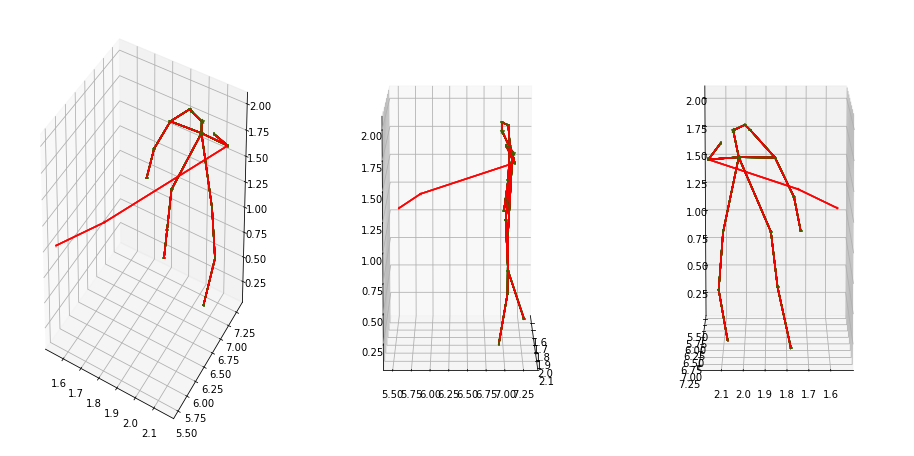

In [23]:
from mvpose.plot.limbs import draw_mscoco_human3d

h = candidates[2]
#h[7] = None
q = gen.apply([h])[0]


fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(131, projection='3d')
draw_mscoco_human3d(ax, h, 'green')
draw_mscoco_human3d(ax, q, 'red', alpha=0.2)

ax = fig.add_subplot(132, projection='3d')
ax.view_init(elev=10., azim=0)
draw_mscoco_human3d(ax, h, 'green')
draw_mscoco_human3d(ax, q, 'red', alpha=0.2)

ax = fig.add_subplot(133, projection='3d')
ax.view_init(elev=10., azim=90)
draw_mscoco_human3d(ax, h, 'green')
draw_mscoco_human3d(ax, q, 'red', alpha=0.2)


plt.show()

mu [1.64054932 5.99003825 0.8847185 ]


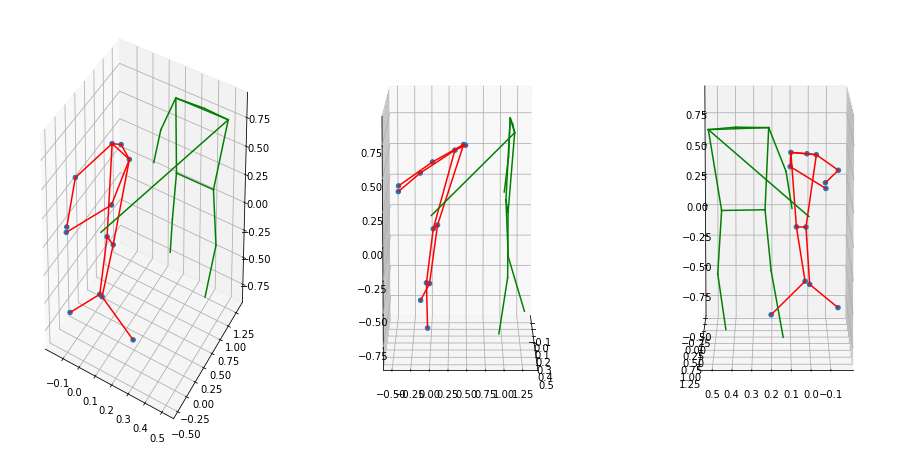

In [24]:
def draw_skeleton(ax, skel, color):
    limbs = np.array([
        (1, 2), (1, 5), (2, 5),
        (2, 3), (3, 4), (5, 6), (6, 7),
        (2, 8), (5, 11), (8, 11),
        (8, 9), (9, 10), (11, 12), (12, 13)
    ]) - 1
    for a, b in limbs:
        x1,y1,z1 = skel[a]
        x2,y2,z2 = skel[b]
        ax.plot([x1, x2], [y1, y2], [z1, z2], color=color)
        
        
model = gen.model

trans_h = ska.transform_from_mscoco([h])[0]

norm_h, mu = ska.normalize(trans_h, 1000)

print('mu', mu)

y_pred = model.predict(norm_h.reshape(1, 13*4)).reshape(1, 13, 3)[0]

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(131, projection='3d')
draw_skeleton(ax, y_pred, 'red')
draw_skeleton(ax, norm_h[:,0:3], 'green')
ax.scatter(y_pred[:,0], y_pred[:,1], y_pred[:,2], alpha=1)

ax = fig.add_subplot(132, projection='3d')
ax.view_init(elev=10., azim=0)
draw_skeleton(ax, y_pred, 'red')
draw_skeleton(ax, norm_h[:,0:3], 'green')
ax.scatter(y_pred[:,0], y_pred[:,1], y_pred[:,2], alpha=1)

ax = fig.add_subplot(133, projection='3d')
ax.view_init(elev=10., azim=90)
draw_skeleton(ax, y_pred, 'red')
draw_skeleton(ax, norm_h[:,0:3], 'green')
ax.scatter(y_pred[:,0], y_pred[:,1], y_pred[:,2], alpha=1)

plt.show()

In [12]:
# h_den = ska.denormalize(y_pred, 1000)


# fig = plt.figure(figsize=(16, 8))
# ax = fig.add_subplot(131, projection='3d')
# draw_skeleton(ax, h_den, 'red')
# #draw_skeleton(ax, norm_h[:,0:3], 'green')
# ax.scatter(y_pred[:,0], y_pred[:,1], y_pred[:,2], alpha=1)

# ax = fig.add_subplot(132, projection='3d')
# ax.view_init(elev=10., azim=0)
# draw_skeleton(ax, h_den, 'red')
# #draw_skeleton(ax, norm_h[:,0:3], 'green')
# ax.scatter(y_pred[:,0], y_pred[:,1], y_pred[:,2], alpha=1)

# ax = fig.add_subplot(133, projection='3d')
# ax.view_init(elev=10., azim=90)
# draw_skeleton(ax, h_den, 'red')
# #draw_skeleton(ax, norm_h[:,0:3], 'green')
# ax.scatter(y_pred[:,0], y_pred[:,1], y_pred[:,2], alpha=1)

# plt.show()

In [13]:
# for left, right in zip(h, q):
#     print(str(left) + ' -> ', right)

In [14]:
# A = np.array([
#     [50, 5, 5, 1],
#     [5, 5, 5, 1],
#     [5, 5, 5, 1],
#     [5, 5, 5, 1],
#     [5, 5, 5, 1],
#     [5, 5, 5, 1],
#     [5, 5, 5, 1],
#     [5, 5, 5, 1],
#     [5, 5, 5, 1],
#     [5, 5, 5, 1],
#     [5, 5, 5, 1],
#     [5, 5, 5, 1],
#     [5, 5, 5, 1],
# ])

# def normalize(indv, scale_to_mm):
#     """
#         normalize the data to be between -1 and 1
#     :param indv:
#     :param scale_to_mm:
#     :return:
#     """
#     result = indv.copy()
#     n_points, n_dims = indv.shape
#     assert n_points == 13
#     assert n_dims == 4
#     pts = indv[:, 0:3]
#     visible = indv[:, 3]
#     div = 1000 / scale_to_mm
#     mu = np.mean(pts, axis=0)
#     result[:, 0:3] = (pts - mu)/div  # because we use mm!
#     for i, v in enumerate(visible):
#         if v == 0:
#             result[i, 0] = 0
#             result[i, 1] = 0
#             result[i, 2] = 0
#     return result, mu


# def denormalize(indv, mu, scale_to_mm):
#     """
#         de-normalizes the data again
#     :param indv:
#     :param scale_to_mm:
#     :return:
#     """
#     div = 1000 / scale_to_mm
#     return (indv + mu) * div


# normA, mu = normalize(A, 1000)

# denormA = denormalize(normA[:,0:3], mu, 1000)


# print(mu)

# ================================

In [15]:
for gtid, data in PER_GTID.items():
    print("hid:", gtid)
    print('larms:\t', np.mean(PER_GTID[gtid]['larms']))
    print('uarms:\t', np.mean(PER_GTID[gtid]['uarms']))
    print('llegs:\t', np.mean(PER_GTID[gtid]['llegs']))
    print('ulegs:\t', np.mean(PER_GTID[gtid]['ulegs']))
    print('avg:\t', np.mean(PER_GTID[gtid]['avg']))

hid: 1
larms:	 0.5957446808510638
uarms:	 0.9973404255319149
llegs:	 0.9973404255319149
ulegs:	 1.0
avg:	 0.8976063829787234
hid: 2
larms:	 0.6617647058823529
uarms:	 0.9154411764705882
llegs:	 1.0
ulegs:	 1.0
avg:	 0.8943014705882353
hid: 0
larms:	 0.5625
uarms:	 0.75
llegs:	 0.9791666666666666
ulegs:	 0.9791666666666666
avg:	 0.8177083333333334


In [16]:
# OLD RESULTS

# hid: 1
# larms:	 0.6090425531914894
# uarms:	 0.9813829787234043
# llegs:	 0.9973404255319149
# ulegs:	 1.0
# avg:	 0.8969414893617021
# hid: 2
# larms:	 0.6360294117647058
# uarms:	 0.8860294117647058
# llegs:	 0.9816176470588235
# ulegs:	 0.9816176470588235
# avg:	 0.8713235294117647
# hid: 0
# larms:	 0.5625
# uarms:	 0.7291666666666666
# llegs:	 1.0
# ulegs:	 1.0
# avg:	 0.8229166666666666

# NEW RESULTS

# hid: 1
# larms:	 0.5957446808510638
# uarms:	 0.9973404255319149
# llegs:	 0.9973404255319149
# ulegs:	 1.0
# avg:	 0.8976063829787234
# hid: 2
# larms:	 0.6617647058823529
# uarms:	 0.9154411764705882
# llegs:	 1.0
# ulegs:	 1.0
# avg:	 0.8943014705882353
# hid: 0
# larms:	 0.5625
# uarms:	 0.75
# llegs:	 0.9791666666666666
# ulegs:	 0.9791666666666666
# avg:	 0.8177083333333334>

FRAME= 716
AVG= 0.75


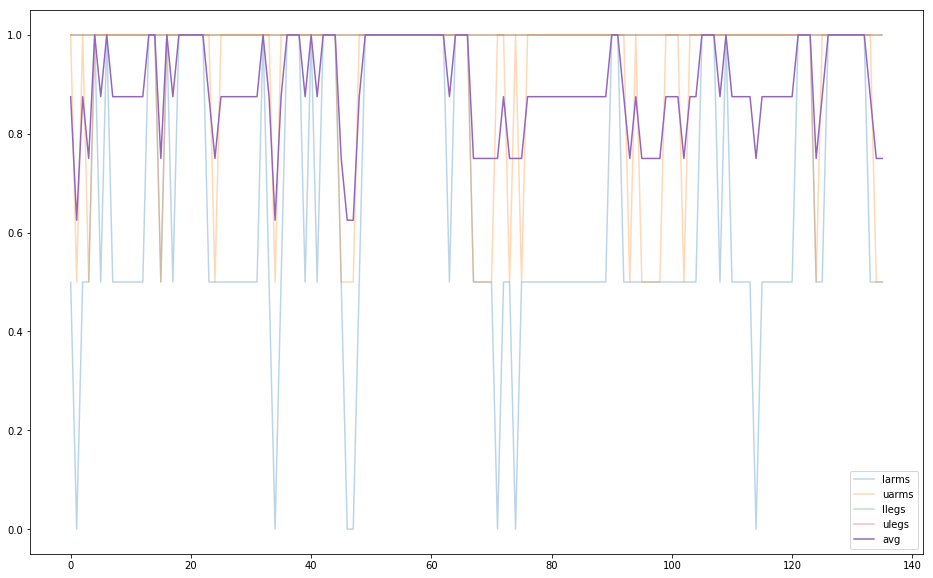

In [17]:
pid = 2
larms = PER_GTID[pid]['larms']
uarms = PER_GTID[pid]['uarms']
llegs = PER_GTID[pid]['llegs']
ulegs = PER_GTID[pid]['ulegs']
avgs = PER_GTID[pid]['avg']
frames = PER_GTID[pid]['frame']

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)

ax.plot(range(len(larms)), larms, label='larms', alpha=0.3)
ax.plot(range(len(larms)), uarms, label='uarms', alpha=0.3)
ax.plot(range(len(larms)), llegs, label='llegs', alpha=0.3)
ax.plot(range(len(larms)), ulegs, label='ulegs', alpha=0.3)
ax.plot(range(len(larms)), avgs, label='avg')

loc = 102

print("FRAME=", frames[loc])
print('AVG=', avgs[loc])

plt.legend()
plt.show()

In [18]:
# competition
Actor0 = [
    .9655,  # uarms
    .8621,  # larms
    .9310,  # ulegs
    .9655   # llegs
]
Actor1 = [.9735, .4294, .75, .8941]
Actor2 = [.8981, .7476, .9175, .7621]

for Actor in [Actor0, Actor1, Actor2]:
    print(np.mean(Actor))

0.931025
0.7617499999999999
0.8313250000000001
